### Installing Spark

Install Dependencies:


1.   Java 8
2.   Apache Spark with hadoop
3.   Findspark (used to locate the spark in the system)


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz

--2021-06-13 06:18:09--  http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228721937 (218M) [application/x-gzip]
Saving to: ‘spark-3.1.1-bin-hadoop3.2.tgz’

spark-3.1.1-bin-had 100%[===================>] 218.13M  18.8MB/s    in 13s     

2021-06-13 06:18:22 (17.1 MB/s) - ‘spark-3.1.1-bin-hadoop3.2.tgz’ saved [228721937/228721937]



In [3]:
!pip install -q findspark

Set Environment Variables:

In [4]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [6]:
import findspark

findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
# Property used to format output tables better
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark

### Load Data

Load Log file as RDD

In [8]:
raw_data = spark.sparkContext.textFile('Log')
# filter lines shorter than 48 (corrupted lines)
raw_data = raw_data.filter(lambda line: len(line)>=48)
# display total items count
raw_data.count()

1891714

Convert RDD to Dataframe

In [9]:
import re

# mapper function (parser function)
def mapper(line):
  host = re.split(' - - ', line)[0]
  details = re.split(' - - ', line)[1]

  timestamp = re.search('\[(.*?)\]', details).group(1).split()[0]
  details = re.sub('\[(.*?)\]', '', details)

  req_items = re.search('"(.*)"', details).group(1).split()
  method = req_items[0] if 0 < len(req_items) else None
  uri = req_items[1] if 1 < len(req_items) else None
  protocol = req_items[2] if 2 < len(req_items) else None
  details = re.sub('"(.*)"', '', details).strip()

  response_code = details.split()[0]
  
  return host, timestamp, method, uri, protocol, response_code

In [10]:
columns = ['host', 'timestamp', 'method', 'uri', 'protocol', 'response code']
df = raw_data.map(mapper).toDF(columns)

In [11]:
from pyspark.sql.functions import col
from pyspark.sql.functions import to_timestamp

# change column type from string to timestamp
df = df.withColumn('timestamp', to_timestamp(df.timestamp,'dd/MMM/yyyy:HH:mm:ss'))
# change column type from string to integer
df = df.withColumn('response code', col('response code').cast('int'))

In [12]:
df.show(10, truncate=True)
df.printSchema()

+--------------------+-------------------+------+--------------------+--------+-------------+
|                host|          timestamp|method|                 uri|protocol|response code|
+--------------------+-------------------+------+--------------------+--------+-------------+
|        199.72.81.55|1995-07-01 00:00:01|   GET|    /history/apollo/|HTTP/1.0|          200|
|unicomp6.unicomp.net|1995-07-01 00:00:06|   GET| /shuttle/countdown/|HTTP/1.0|          200|
|      199.120.110.21|1995-07-01 00:00:09|   GET|/shuttle/missions...|HTTP/1.0|          200|
|  burger.letters.com|1995-07-01 00:00:11|   GET|/shuttle/countdow...|HTTP/1.0|          304|
|      199.120.110.21|1995-07-01 00:00:11|   GET|/shuttle/missions...|HTTP/1.0|          200|
|  burger.letters.com|1995-07-01 00:00:12|   GET|/images/NASA-logo...|HTTP/1.0|          304|
|  burger.letters.com|1995-07-01 00:00:12|   GET|/shuttle/countdow...|HTTP/1.0|          200|
|     205.212.115.106|1995-07-01 00:00:12|   GET|/shuttle/co

### Part 1

Count distinct hosts

In [13]:
df.select('host').distinct().count()

81982

### Part 2

Caculate average request for each host per day

In [14]:
from pyspark.sql.functions import to_date

res_df = df.groupBy('host', to_date('timestamp')).count().groupBy('host').mean()
res_df.show(10, truncate=True)

+--------------------+------------------+
|                host|        avg(count)|
+--------------------+------------------+
|sldar1p10.ozemail...|               4.0|
|      128.159.63.129|               6.0|
|  ppp213.telepost.no|              11.0|
|n1135849.ksc.nasa...|13.714285714285714|
|   linus.cs.tamu.edu|              16.0|
|        206.64.50.15|              10.0|
|dd05-020.compuser...|               2.2|
|  enigma.idirect.com|             31.76|
|drjo013a072.embra...| 9.666666666666666|
|      198.88.100.197|               5.5|
+--------------------+------------------+
only showing top 10 rows



### Part 3

Count total gif file requested

In [15]:
df.filter(df.uri.endswith('.gif')).count()

1029475

### Part 4

Find most requested host names
- Filter hosts that ip addressed
- Filter hosts requested less that 3 times

In [16]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

import re

# function for filtering ip addressed hosts
def hn_filter(host):
  return not bool(re.match(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$", host))

# convert python function to spark user defined function
hn_filter_udf = udf(hn_filter, BooleanType())

In [17]:
from pyspark.sql.functions import col

# filter ip addressed hosts
filtered_df = df.filter(hn_filter_udf(df.host))

res_df = filtered_df.groupBy('host').count().filter(col('count')>3)
res_df.orderBy('count', ascending=False).show(10, truncate=True)

+--------------------+-----+
|                host|count|
+--------------------+-----+
|piweba3y.prodigy.com|17572|
|piweba4y.prodigy.com|11591|
|piweba1y.prodigy.com| 9868|
|  alyssa.prodigy.com| 7852|
| siltb10.orl.mmc.com| 7573|
|piweba2y.prodigy.com| 5922|
|  edams.ksc.nasa.gov| 5434|
|         news.ti.com| 4863|
|disarray.demon.co.uk| 4353|
|www-a2.proxy.aol.com| 4179|
+--------------------+-----+
only showing top 10 rows



Find most requested hosts per day
- Filter hosts that ip addressed
- Filter hosts requested less that 3 times

In [18]:
from pyspark.sql.functions import to_date

# filter ip addressed hosts
filtered_df = df.filter(hn_filter_udf(df.host))

res_df = filtered_df.groupBy('host', to_date('timestamp')).count()
res_df = res_df.orderBy('count', ascending=False).dropDuplicates(['to_date(timestamp)'])
res_df.orderBy('to_date(timestamp)').show(10, truncate=True)

+--------------------+------------------+-----+
|                host|to_date(timestamp)|count|
+--------------------+------------------+-----+
|piweba3y.prodigy.com|        1995-07-01|  623|
|piweba3y.prodigy.com|        1995-07-02|  960|
|piweba3y.prodigy.com|        1995-07-03| 1067|
|piweba3y.prodigy.com|        1995-07-04| 1199|
|         news.ti.com|        1995-07-05|  826|
|piweba3y.prodigy.com|        1995-07-06|  732|
|piweba3y.prodigy.com|        1995-07-07|  879|
|piweba3y.prodigy.com|        1995-07-08|  781|
|  alyssa.prodigy.com|        1995-07-09|  545|
|  e659229.boeing.com|        1995-07-10|  358|
+--------------------+------------------+-----+
only showing top 10 rows



### Part 5

Display response errors (!= 200) frequency graphically

In [22]:
res_df = df.filter(col('response code')!=200).groupBy('response code').count()

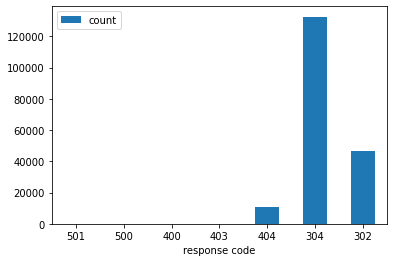

In [23]:
import matplotlib.pyplot as plt

res_pdf = res_df.toPandas()
res_pdf.plot.bar(x='response code', y='count', rot=0)
plt.savefig('error_freq.jpg')